# OFAT SA

In [3]:
%matplotlib inline
from model import *
from agents import *
from globals import *
from server import *
from schedule import *
from utility import *
from SALib.sample import saltelli
from mesa.batchrunner import BatchRunner
from SALib.analyze import sobol
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

fixed_params = {
    "network_type": 1,
    "N": 100,
    "no_of_neighbors": 2,
    #"beta_component": 0.15,
    "similarity_treshold": 0.0,
    "social_influence": 0.0,
    "swingers": 0
}

variable_params = {
    #"N": range(100, 20, 50),
    #"no_of_neighbors": range(1, 3),
    "beta_component": np.arange(0.0, 1.0, 0.2),
    #"similarity_treshold": np.arange(0.0, 1.0, 0.5),
    #"social_influence": np.arange(0.0, 1.0, 0.5),
    #"swingers": range(0, 3)
}


# Set the repetitions, the amount of steps, and the amount of distinct values per variable
replicates = 5
max_steps = 20

# Set the outputs
model_reporters = {
                "preferences": compute_preferences,
                "opinions": compute_opinions,
                "preference_A": compute_preference_A,
                "preference_B": compute_preference_B,
                "radical_opinions": compute_radical_opinions,
                "community_no": community_no,
}

data = {}

  
batch = BatchRunner(Network, 
                    max_steps=max_steps,
                    iterations=replicates,
                    fixed_parameters=fixed_params,
                    variable_parameters=variable_params,
                    model_reporters=model_reporters,
                    display_progress=True)
    
batch.run_all()
data = batch.get_model_vars_dataframe()

#print data
print(data)

25it [02:49,  6.66s/it]


    beta_component  Run  community_no  opinions  preference_A  preference_B  \
0              0.0    0            12      0.59      0.560038      0.529307   
1              0.0    1            10      0.66      0.591752      0.575313   
2              0.0    2            12      0.48      0.612076      0.680874   
3              0.0    3            10      0.55      0.581252      0.528625   
4              0.0    4            11      0.38      0.543404      0.636661   
5              0.2    5            13      0.40      0.573349      0.548005   
6              0.2    6            14      0.64      0.596191      0.603927   
7              0.2    7            11      0.30      0.570062      0.548658   
8              0.2    8            14      0.59      0.641998      0.543173   
9              0.2    9            12      0.59      0.465867      0.519148   
10             0.4   10            11      0.50      0.577044      0.605658   
11             0.4   11            13      0.46     

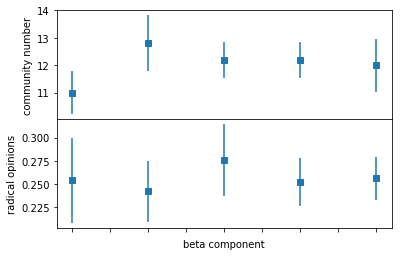

In [4]:
# Example plots for varying beta component

replicates = 5
distinct_samples = 5

beta_component = np.arange(0.0, 1.0, 0.2)

# community number
count=0
list_mean_community_no = []
list_err_community_no = []
for i in range(distinct_samples):
    community_no = []
    for j in range(replicates):
        community_no.append(data.community_no[count + j])
    count = count + j + 1
    mean = np.mean(community_no)
    std = np.std(community_no)
    err = 1.96 * std / np.sqrt(replicates)
    list_mean_community_no.append(mean)
    list_err_community_no.append(err)

# radical opinions
count=0
list_mean_radical_opinions = []
list_err_radical_opinions = []
for i in range(distinct_samples):
    radical_opinions = []
    for j in range(replicates):
        radical_opinions.append(data.radical_opinions[count + j])
    count = count + j + 1
    mean = np.mean(radical_opinions)
    std = np.std(radical_opinions)
    err = 1.96 * std / np.sqrt(replicates)
    list_mean_radical_opinions.append(mean)
    list_err_radical_opinions.append(err)


ax1 = plt.subplot(211, xticklabels=[])
plt.errorbar(beta_component, list_mean_community_no, yerr=list_err_community_no, marker='s', linestyle='None')
plt.ylabel('community number')

ax2 = plt.subplot(212, sharex = ax1)
plt.errorbar(beta_component, list_mean_radical_opinions, yerr=list_err_radical_opinions, marker='s', linestyle='None')
plt.xlabel('beta component')
plt.ylabel('radical opinions')

plt.subplots_adjust(hspace=.0)
plt.show()

# Sobol SA

I also tried sobol sensitivity analysis, but this doesn't work (yet)...

In [3]:
%matplotlib inline
from model import *
from agents import *
from globals import *
from server import *
from schedule import *
from utility import *
from SALib.sample import saltelli
from mesa.batchrunner import BatchRunner
from SALib.analyze import sobol
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

# We define our variables and bounds

fixed_params = {
    "network_type": 1
}

problem = {
    'num_vars': 6,
    'names': ['N', 'no_of_neighbors', 'beta_component', 'similarity_treshold', 'social_influence', 'swingers'],
    'bounds': [[50, 250], [0, 5], [0.01, 1.0], [0.01, 1.0], [0.01, 1.0], [1, 5]]
}

# Set the repetitions, the amount of steps, and the amount of distinct values per variable
replicates = 5
max_steps = 30
distinct_samples = 2

# We get all our samples here
param_values = saltelli.sample(problem, distinct_samples)

# Set the outputs
model_reporters = {
                "preferences": compute_preferences,
                "opinions": compute_opinions,
                "preference_A": compute_preference_A,
                "preference_B": compute_preference_B,
                "radical_opinions": compute_radical_opinions,
                "community_no": community_no,
}


# BatchRunner
batch = BatchRunner(Network, 
                    max_steps=max_steps,
                    fixed_parameters=fixed_params,
                    variable_parameters={name:[] for name in problem['names']},
                    model_reporters=model_reporters)

count = 0
for i in range(replicates):
    for vals in param_values: 
        # Change parameters that should be integers
        vals = list(vals)
        vals[2] = int(vals[2])

        # Transform to dict with parameter names and their values
        variable_parameters = {}
        for name, val in zip(problem['names'], vals):
            variable_parameters[name] = val

        batch.run_iteration(variable_parameters, tuple(vals), count)
        count += 1

        clear_output()
        print(f'{count / (len(param_values) * (replicates)) * 100:.2f}% done')
    
data = batch.get_model_vars_dataframe()
print(data)

TypeError: __init__() missing 1 required positional argument: 'network_type'